In [1]:
%pip install langgraph
%pip install langchain-openai
%pip install python-dotenv
%pip install langchain-community

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain_community.llms import Ollama
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

In [9]:
class State(TypedDict):
    text: str
    analyze: str

llm = Ollama(model="llama3.1")

In [10]:
def analyze_node(state: State):
    ''' Classifica o texto em uma das categorias: Notícias, Blog, Pesquisa ou Outro '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="""Dado o seguinte texto, identifique todas as entidades mencionadas que podem ser representadas como tabelas em um banco de dados, e para cada entidade, identifique suas características (colunas) relevantes. Formate a resposta da seguinte forma:
                    Entidade: [Nome da Entidade]
                    Colunas:
                    1. [Nome da Coluna]
                    2. [Nome da Coluna]

                    Texto:{text}
                    ...
                    """
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    analyze = llm.invoke([message]).strip()
    return {"analyze": analyze}


In [11]:
workflow = StateGraph(State)

# Adicionar nós ao grafo
workflow.add_node("analyze_node", analyze_node)

# Adicionar arestas ao grafo
workflow.set_entry_point("analyze_node") # Definir o ponto de entrada do grafo
workflow.add_edge("analyze_node", END)

# Compilar o grafo
app = workflow.compile()

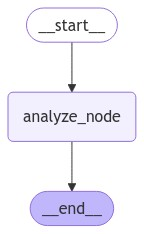

In [12]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [13]:
sample_text = """
    No consultório odontológico ‘Dentibão’, situado na rua ‘X’, nº ‘1’ na cidade ‘Y’, estado de MG (‘Dentibão’ só poderia ser de MG né? rsrs), as consultas funcionam por ordem de chegada dos pacientes da seguinte maneira: 
    O paciente, ao chegar no consultório, obtém do atendente uma senha numérica de ordem crescente e aguarda até o momento de ser chamado. 
    O atendente chama os pacientes pela ordem das senhas. Inicialmente o atendente solicita o nome do paciente e procura a ficha dele no arquivo de pacientes (que está em ordem alfabética). 
    Se o paciente ainda não tiver ficha no consultório, então o atendente solicita os dados básicos do paciente para criar uma ficha para ele, estes dados são: CPF, Nome, Data de nascimento, endereço e telefones.
    Com a ficha do paciente em mãos, o atendente pergunta ao paciente o motivo da consulta, que geralmente é consulta de rotina ou dor de dente. Então o atendente cria uma ficha de atendimento com as informações de motivo da consulta, anexa à ficha do paciente e coloca em baixo da pilha de fichas para atendimentos do dentista. 
    Neste momento o atendente diz ao paciente que espere que o dentista o chame, e finaliza o atendimento.
    O dentista chama os pacientes pela ordem que o atendente organizou a pilha de fichas, mas antes de chamar cada paciente, o dentista analisa o histórico de atendimentos do paciente e o motivo que ele (paciente) descreveu para a consulta atual. 
    Após atender o paciente, o dentista descreve detalhes do atendimento na ficha de atendimento, como diagnóstico, receita de remédios, solicitação de retorno, etc. 
    Finaliza-se a consulta e paciente é liberado.
"""

state_input = {"text": sample_text}
result = app.invoke(state_input)

print("Analyze:", result["analyze"])

Analyze: Entidade: Consultório Odontológico 'Dentibão'
Colunas:
1. Nome
2. Endereço (rua e número)
3. Cidade
4. Estado
5. Estado de funcionamento

Entidade: Paciente
Colunas:
1. CPF
2. Nome
3. Data de nascimento
4. Endereço
5. Telefones
6. Senha numérica de ordem crescente (para a ordem de chamada no consultório)

Entidade: Atendente
Colunas:
1. Número de identificação ou nome (não foi mencionado explicitamente)

Entidade: Arquivo de pacientes
Colunas:
1. Nome do paciente
2. Ficha completa dos dados básicos dos pacientes

Entidade: Ficha do paciente
Colunas:
1. CPF
2. Nome
3. Data de nascimento
4. Endereço
5. Telefones

Entidade: Ficha de atendimento
Colunas:
1. Motivo da consulta
2. Informações adicionais (anexadas à ficha do paciente)
3. Descrição detalhada dos serviços prestados pelo dentista
4. Diagnóstico
5. Receita de remédios
6. Solicitações de retorno
